In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [2]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [3]:
import pandas as pd

df = pd.DataFrame([('Liam', 'M', 19659, 2020), ('Noah', 'M', 18252, 2020),
                   ('Oliver', 'M', 14147, 2020), ('Elijah', 'M', 13034, 2020),
                   ('William', 'M', 12541, 2020), ('Emma', 'F', 15581, 2020),
                   ('Ava', 'F', 13084, 2020), ('Charlotte', 'F', 13003, 2020),
                   ('Sophia', 'F', 12976, 2020), ('Amelia', 'F', 12704, 2020)],
                  columns=['Name', 'Sex', 'Count', 'Year'])

df2 = df.sort_values('Name')

(ch:pa_cleaning_aqs)=
# Exploring and Cleaning AQS Sensor Data

Let's briefly take stock of where we are in the analysis.
Our plan is roughly to:

1. Find a list of possibly collocated AQS and PurpleAir sensors.
2. Contact AQS sites find truly collocated sensor pairs.
3. Explore and clean AQS measurements for one sensor.
4. Explore and clean PurpleAir measurements for the other sensor in the pair,
   then join the measurements together.
5. Join all the measurements together for all the sensor pairs. 
6. Fit a model to make PurpleAir measurements match AQS measurements.

We finished step 1 in the previous section ({numref}`ch:pa_collocated`). We
skipped step 2; we
decided to reuse Barkjohn's list of truly collocated sensor pairs rather than
contacting the AQS sites ourselves.

In this section, we'll proceed to step 3 of the analysis plan:
to explore and clean data from one AQS sensor.

We picked a sensor pair from Barkjohn's list of collocated sensors.
The pair is located in Sacramento, California. The AQS sensor ID is
`06-067-0010`, and the PurpleAir sensor name is `AMTS_TESTINGA`.

The AQS provides a website and API to download sensor data [^aqs_api].
For this sensor, Barkjohn's analysis used data from May 20, 2018 to Dec 29, 2019.
We downloaded the daily measurements for these dates into the
`data/aqs_06-067-0010.csv` file. We'll begin by loading this file into `pandas`.

[^aqs_api]: https://aqs.epa.gov/aqsweb/documents/data_api.html

In [7]:
aqs = pd.read_csv('data/aqs_06-067-0010.csv')
aqs.head(2)

,state_code,county_code,site_number,parameter_code,...,city,cbsa_code,cbsa,date_of_last_change
0,6,67,10,88101,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24
1,6,67,10,88101,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24


As usual, this dataframe has too many columns to display in the notebook.
We'll display the first row of data to see all the columns. 

In [8]:
display_df(aqs.iloc[0].to_frame(), rows=31)

,0
state_code,6
county_code,67
site_number,10
parameter_code,88101
poc,1
latitude,38.57
longitude,-121.49
datum,NAD83
parameter,PM2.5 - Local Conditions
sample_duration,24 HOUR


From the data dictionary for this data [^aqs_dict], we can find out that the
`arithmetic_mean` column corresponds to the actual PM2.5 measurements. Some AQS
sensors take a measurement every hour. 
For our analysis, we downloaded the 24-hour averages (the arithmetic mean) of the
hourly sensor measurements.

[^aqs_dict]: https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_hourly_data_files

Before we can use this data for analysis, we'll perform validity checks with a
combination of EDA and visualization, then clean the data where necessary.

We will:

1. Check and correct the granularity of the data.
1. Remove unneeded columns.
1. Check validity of the `date_local` column.
1. Check validity of the `arithmetic_mean` column.

There are many more checks we could perform on this data. If we were planning
to publish this work more broadly, we would be as thorough as possible.
For the sake of brevity, we've chosen a few important validity checks that
specifically reinforce ideas we've covered in data wrangling, EDA, and visualization.

## What's the Granularity?

We would like each row of our data to correspond to a single date with an average
PM2.5 reading for that date. Is this the case for the `aqs` dataframe?
One simple way to check is to see whether there are repeat values in the
`date_local` column. 

In [9]:
aqs['date_local'].value_counts()

2019-05-12    12
2019-11-14    12
2019-09-03    12
              ..
2019-01-30    12
2019-12-23    12
2019-05-27    12
Name: date_local, Length: 189, dtype: int64

Indeed, there are 12 rows for each date in `aqs`. So, the granularity is *not* 
at the individual date level. To figure out why this happens, we can filter the
table to a single date, then look for columns that have different values within
that date.
If we do this, we find that the `pollutant_standard` and `event_type` columns
differ within a date.
Here, we display these columns for the date
`2018-12-31`:

In [10]:
one_date = (aqs.query('date_local == "2018-12-31"')
 [['date_local', 'pollutant_standard', 'event_type', 'arithmetic_mean']]
)
display_df(one_date, rows=12)

,date_local,pollutant_standard,event_type,arithmetic_mean
0,2018-12-31,PM25 24-hour 2006,None,3.1
1,2018-12-31,PM25 24-hour 2006,Included,3.1
140,2018-12-31,PM25 Annual 2006,None,3.1
141,2018-12-31,PM25 Annual 2006,Included,3.1
280,2018-12-31,PM25 24-hour 2012,None,3.1
281,2018-12-31,PM25 24-hour 2012,Included,3.1
420,2018-12-31,PM25 Annual 2012,None,3.1
421,2018-12-31,PM25 Annual 2012,Included,3.1
560,2018-12-31,PM25 24-hour 1997,None,3.1
561,2018-12-31,PM25 24-hour 1997,Included,3.1


From the data dictionary, we learn that there are multiple standards for
computing the final measurements from the raw sensor data.
The `pollutant_standard` column contains the name of each standard.
The `event_type` column marks whether data measured during "exceptional events"
are included in the measurement.

However, for our data these columns seem to have no effect on the PM2.5
measurements.
For example, in the `2018-12-31` data above the PM2.5 measurements
are all identical. 
We can verify this for the rest of the data by checking that the
maximum PM2.5 minus the minimum PM2.5 for each date is equal to zero.

In [11]:
(aqs
 .groupby('date_local')
 ['arithmetic_mean']
 .agg(np.ptp) # np.ptp computes max() - min()
 .value_counts()
)
# For all 189 dates, the max PM2.5 - min PM2.5 is 0

0.0    189
Name: arithmetic_mean, dtype: int64

So, we can simply take the first PM2.5 measurement for each date.

In [12]:
def rollup_dates(df):
    return (
        df.groupby('date_local')
        .first()
        .reset_index()
    )

In [13]:
aqs = (pd.read_csv('data/aqs_06-067-0010.csv')
       .pipe(rollup_dates))
aqs.head(2)

,date_local,state_code,county_code,site_number,...,city,cbsa_code,cbsa,date_of_last_change
0,2018-05-20,6,67,10,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24
1,2018-05-23,6,67,10,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24


This data cleaning step gives us the desired granularity of `aqs`:
every row in `aqs` represents a single date, with an average PM2.5
measurement for that date.

## Removing Unneeded Columns

We plan to match the PM2.5 measurements in the `aqs` dataframe with
the PurpleAir PM2.5 measurements for each date.
To simplify the data, we'll subset out the date and PM2.5 columns and rename the
PM2.5 column so that it's easier to understand.

In [30]:
def subset_cols(df):
    subset = df[['date_local', 'arithmetic_mean']]
    return subset.rename(columns={'arithmetic_mean': 'pm25'})

In [31]:
aqs = (pd.read_csv('data/aqs_06-067-0010.csv')
       .pipe(rollup_dates)
       .pipe(subset_cols))
aqs

,date_local,pm25
0,2018-05-20,6.5
1,2018-05-23,2.3
2,2018-05-29,11.8
...,...,...
186,2019-12-23,5.7
187,2019-12-26,2.0
188,2019-12-29,19.5


## Checking the Validity of `date_local`

Let's take a closer look at the `date_local` column.
We can already see that there are gaps in dates where there are no
PM2.5 readings.

In [18]:
# The table is sorted by `date_local`, so we see that there are missing dates
# between 2018-05-20 and 2018-05-23, for example.
aqs

,date_local,pm25
0,2018-05-20,6.5
1,2018-05-23,2.3
2,2018-05-29,11.8
...,...,...
186,2019-12-23,5.7
187,2019-12-26,2.0
188,2019-12-29,19.5


We can check that the `date_local` column contains strings:

In [24]:
# Python strings are recorded as the `object` type in pandas
aqs.dtypes

date_local     object
pm25          float64
dtype: object

In [25]:
aqs['date_local'].iloc[0]

'2018-05-20'

However, we'd like to know: are all the strings valid dates? If so, we can
parse the dates as `pd.Timestamp` objects which will make it easier to compute
the dates that are missing from the data.

The `date_local` values appear to come in the format: `YYYY-MM-DD`, where `YYYY`,
`MM`, and `DD` correspond to the year, month, and day.
The `pd.to_datetime()` method can parse the date strings into objects, and
we can pass in the format of the dates as a date format string [^strftime].

[^strftime]: For more about date format strings, see the quick reference at
https://strftime.org/ or
[the Python documentation](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).

In [26]:
# This is the Python representation of the YYYY-MM-DD format
date_format = '%Y-%m-%d'

pd.to_datetime(aqs['date_local'], format=date_format)

0     2018-05-20
1     2018-05-23
2     2018-05-29
         ...    
186   2019-12-23
187   2019-12-26
188   2019-12-29
Name: date_local, Length: 189, dtype: datetime64[ns]

We see that the `dtype` of this series is `datetime64[ns]` rather than `object`,
which means that the values are `pd.TimeStamp` objects rather than strings.
Also, the method runs without erroring, indicating that all the strings matched the format.

Now, we can reassign the `date_local` column as `pd.TimeStamp`s.

In [27]:
def parse_dates(df):
    date_format = '%Y-%m-%d'
    timestamps = pd.to_datetime(df['date_local'], format=date_format)
    return df.assign(date_local=timestamps)

In [32]:
aqs = (pd.read_csv('data/aqs_06-067-0010.csv')
       .pipe(rollup_dates)
       .pipe(subset_cols)
       .pipe(parse_dates))
aqs

,date_local,pm25
0,2018-05-20,6.5
1,2018-05-23,2.3
2,2018-05-29,11.8
...,...,...
186,2019-12-23,5.7
187,2019-12-26,2.0
188,2019-12-29,19.5


In [29]:
aqs.dtypes

date_local    datetime64[ns]
pm25                 float64
dtype: object

:::{note}

Just because the dates can be parsed doesn't mean that the dates are immediately
ready to use for further analysis. For instance, the string `9999-01-31` can be
parsed into a `pd.TimeStamp`, but the date isn't valid.

:::

Now that the `date_local` contains timestamps, we can calculate how
many dates are missing. We'll find the number of days between the earliest and
latest date---this corresponds to the maximum number of measurements we could
have recorded.

In [35]:
date_range = aqs['date_local'].max() - aqs['date_local'].min()
date_range

Timedelta('588 days 00:00:00')

In [36]:
# Subtracting timestamps give Timedelta objects, which have a few useful
# properties like:
date_range.days

588

In [39]:
print(f'We have {len(aqs)} / {date_range.days} measurements, '
      f'or {len(aqs) / date_range.days:.0%} of the dates possible.')

We have 189 / 588 measurements, or 32% of the dates possible.


There are many dates missing from the data. However, when we combine this
data with the data from the other AQS and PurpleAir sensors, we
expect that we'll have enough data to fit a model.

There are other modeling scenarios where this amount of missing data might
cause more concern, and we've included an exercise at the end of this chapter
to think about potential issues.

## Checking the Validity of `pm25`

There are a few checks we can perform on the PM2.5 measurements.
First, PM2.5 can't go below 0.
Second, we can look for abnormally high PM2.5 values and see whether they
correspond to major events like a wildfire.

One simple way to perform these checks is to plot the PM2.5 against the date.

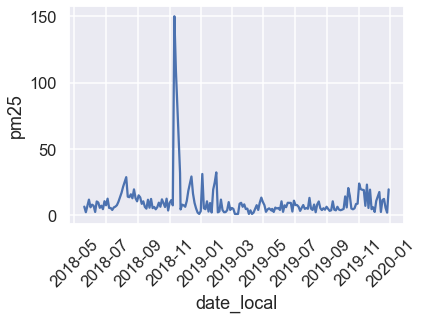

In [51]:
sns.lineplot(data=aqs, x='date_local', y='pm25')
# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45);

We can see that the PM2.5 measurements don't go below 0.

We also a large spike in PM2.5 around November of 2018. This sensor is located
in Sacramento, CA---was there a fire around that area?

Indeed, November 8, 2018 marks the start of the Camp Fire, the "deadliest and
most destructive wildfire in California history" {cite}`bureauCamp2018`. The fire
started just 80 miles north of Sacramento, so this AQS sensor captured the
dramatic spike in PM2.5.

## Next Steps

We've cleaned and explored the data for an AQS sensor.
In the next section, we'll do the same for its collocated PurpleAir sensor.